In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
import statistics
from matplotlib.patches import FancyArrow
import json
import textstat
import re


plt.rcParams['figure.dpi'] = 900

# 将X/Y轴的刻度线方向设置向内
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# 设置字体
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Microsoft Yahei'

# 设置公式字体
config = {
    "mathtext.fontset": 'stix',
}
rcParams.update(config)

    
def appear_times_for_single(data, phrase):
    times = 0
    for i,ele in enumerate(data):
        if phrase in list(ele['phrase'].keys()):
            times += ele['phrase'][phrase]
    return times    


def count_bins(number):
    n_string = '{:.15f}'.format(number)
    decimal_part = str(n_string).split('.')[1]  # 将小数部分转换为字符串并分割
    count = 0
    for digit in decimal_part:
        if digit == '0':
            count += 1
        else:
            break  # 遇到第一个非零数字就停止计数
    return count + 1


# Michel 2007 计算频区间的中心值
def get_center_value(freqs):
    maxi = np.log10(max(freqs))
    minu = np.log10(min(freqs))
    center = (maxi + minu) / 2  # logarithmic mean 对数均值
    return 10**center


# 计算置信区间
def get_confidence_interval(data, confidence_level):
    n = len(data)  # 样本大小
    mean = np.mean(data)  # 样本均值
    std_err = stats.sem(data)  # 样本标准误差
    # 使用 t 分布计算置信区间（适用于样本较小的情况）
    t_value = stats.t.ppf((1 + confidence_level) / 2, df=n-1)  # t 分布临界值
    margin_of_error = t_value * std_err  # 误差范围
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)  # 置信区间
    return confidence_interval


def search(data, phrase):
    results = []
    for ele in data:
        if phrase == ele['Latin phrase']:
            results.append(ele)
    return results
            
            
# 获取拉丁文本的音节数量
def get_latin_syllable(latin_):
    # 拉丁单词的音节数量为 元音+双元音 的数量
    pattern = re.compile('(ae|au|ei|eu|oe|ui|[aeiouy])')
    count = len(pattern.findall(latin_))
    return count


# 获取 Flesch kincaid grade
def get_flesch_kincaid_grade(latin_phrase, mixed_, llmed_):
    latin_syllable = get_latin_syllable(latin_phrase)
    total_syllable = textstat.syllable_count(mixed_.replace(latin_phrase, '')) + latin_syllable
    total_words = textstat.lexicon_count(mixed_, removepunct=True)
    total_sentences = textstat.sentence_count(mixed_)
    mixed_score = 0.39 * (total_words / total_sentences) + 11.8 * (total_syllable / total_words) - 15.59
    # print(total_sentences, total_words, total_syllable)
    llmed_score = textstat.flesch_kincaid_grade(llmed_)
    rate = (mixed_score - llmed_score) / (((mixed_score + llmed_score)) / 2)
    
    return mixed_score, llmed_score, rate


def get_flesch_reading_ease(latin_phrase, mixed_, llmed_):
    # 计算ASL（平均句子长度）
    sentence_count = textstat.sentence_count(mixed_)  # 获取句子数
    word_count = textstat.lexicon_count(mixed_)  # 获取单词数
    asl = word_count / sentence_count
    # 计算ASW（平均每个单词的音节数）
    latin_syllable = get_latin_syllable(latin_phrase)
    total_syllable = textstat.syllable_count(mixed_.replace(latin_phrase, '')) + latin_syllable
    asw = total_syllable / word_count
    mixed_score = 206.835 - (1.015 * asl) - (84.6 * asw)
    llmed_score = textstat.flesch_reading_ease(llmed_)
    rate = (mixed_score - llmed_score) / (((mixed_score + llmed_score)) / 2)
    
    return mixed_score, llmed_score, rate


def get_smog_index(latin_phrase, mixed_, llmed_):
    # 多音节单词数量
    polysyllable_count = 0
    for word in latin_phrase.split():
        if get_latin_syllable(word) >= 3:
            polysyllable_count += 1
    for word in mixed_.replace(latin_phrase, '').split():
        syllable_count = textstat.syllable_count(word)
        if syllable_count >= 3:
            polysyllable_count += 1
    mixed_score = 1.043 * np.sqrt(polysyllable_count * (30 / textstat.sentence_count(mixed_))) + 3.1291
    llmed_score = textstat.smog_index(llmed_)
    rate = (mixed_score - llmed_score) / (((mixed_score + llmed_score)) / 2)
    
    return mixed_score, llmed_score, rate


def get_coleman_liau_index(latin_phrase, mixed_, llmed_):
    mixed_score = textstat.coleman_liau_index(mixed_)
    llmed_score = textstat.coleman_liau_index(llmed_)
    if mixed_score == 0 and llmed_score == 0:
        return 0, 0, 0
    else:
        rate = (mixed_score - llmed_score) / (((mixed_score + llmed_score)) / 2)
        
        return mixed_score, llmed_score, rate


def get_gunning_fog_index(latin_phrase, mixed_, llmed_):
    # 多音节单词数量
    polysyllable_count = 0
    for word in latin_phrase.split():
        if get_latin_syllable(word) >= 3:
            polysyllable_count += 1
    for word in mixed_.replace(latin_phrase, '').split():
        syllable_count = textstat.syllable_count(word)
        if syllable_count >= 3:
            polysyllable_count += 1
    total_words = textstat.lexicon_count(mixed_, removepunct=True)
    total_sentences = textstat.sentence_count(mixed_)
    complex_words = polysyllable_count
    mixed_score = 0.4 * ( (total_words / total_sentences) + 100 * (complex_words / total_words) )
    llmed_score = textstat.gunning_fog(llmed_)
    rate = (mixed_score - llmed_score) / (((mixed_score + llmed_score)) / 2)
    
    return mixed_score, llmed_score, rate

#### 认知困难测试

In [25]:
# 计算每个句子与的分数值，并按照{'de facto': [0.23, 0.25]} 词组-分差对的形式保存(分别计算n-grams, 2-grams, other-grams)
def get_calculate_index_pair(llmed_list, calculate_index):
    j = 0
    n = 0
    score_dict = {}
    score_dict_2grams = {}
    score_dict_othergrams = {}
    for i, ele in enumerate(llmed_list):
        # <<<<<<使用带有相似度数据集>>>>>>
        latin_phrase = ele['Latin phrase']
        local_sentence = ele['local sentence']
        llmed_response = ele['llmed response']
        score = ele['similarity score']
        
        llmed_sentence = ''
        if 0.999 > score >= 0.9:
            llmed_sentence = llmed_response
            n += 1
        else:
            continue
        
        # 选择评价指标
        s1, s2, rate = 0, 0, 0
        if calculate_index == 'FKGL':
            s1, s2, rate = get_flesch_kincaid_grade(latin_phrase, local_sentence, llmed_sentence)
        elif calculate_index == 'FRE':
            s1, s2, rate = get_flesch_reading_ease(latin_phrase, local_sentence, llmed_sentence)
        elif calculate_index == 'GFI':
            s1, s2, rate = get_gunning_fog_index(latin_phrase, local_sentence, llmed_sentence)
        elif calculate_index == 'SMOG':
            s1, s2, rate = get_smog_index(latin_phrase, local_sentence, llmed_sentence)
        elif calculate_index == 'CLI':
            s1, s2, rate = get_coleman_liau_index(latin_phrase, local_sentence, llmed_sentence)
            
        if s1 - s2 > 0:
            j += 1
        # 构建 {'de facto': [0.23, 0.25]} 词组-分差 对
        para = s1 - s2
        # para = rate
        if latin_phrase not in list(score_dict.keys()):
            score_dict[latin_phrase] = [para]
        else :
            score_dict[latin_phrase].append(para)
        if len(latin_phrase.split(' ')) == 2:
            if latin_phrase not in list(score_dict_2grams.keys()):
                score_dict_2grams[latin_phrase] = [para]
            else :
                score_dict_2grams[latin_phrase].append(para)
        else:
            if latin_phrase not in list(score_dict_2grams.keys()):
                score_dict_othergrams[latin_phrase] = [para]
            else :
                score_dict_othergrams[latin_phrase].append(para)
    return [score_dict, score_dict_2grams, score_dict_othergrams]
    
    
# 获取C4EL中每个词组的出现次数
def get_appear_times_in_C4EL():           
    # 获取词组的出现次数
    appear_times_in_C4EL = {}
    df_appear_times = pd.read_csv('data/data analysis v2.0/latin phrase in data v1.0.csv')
    for pha, appear_times in zip(df_appear_times['phrase'], df_appear_times['appear times']):
        appear_times_in_C4EL[pha] = appear_times
    return appear_times_in_C4EL
    
    
# 构建频率与每个词组的分数值之间的关系
def get_readability_of_frequency(llmed_list, calculate_index):
    results_of_readability = []
    
    appear_times_in_C4EL = get_appear_times_in_C4EL()
    score_dict, score_dict_2grams, score_dict_othergrams = get_calculate_index_pair(llmed_list, calculate_index)
    
    for dict_ in [score_dict, score_dict_2grams, score_dict_othergrams]:
        dict_rate = {}
        for key, val in dict_.items():
            rate = np.median(val)
            # rate = np.average(val)
            dict_rate[key] = rate
        # 构建频率与可读性公式的关系
        total_wards_in_LE = 474105865
        dict_frequency = {}
        # 获取频率数据
        for pha, times in appear_times_in_C4EL.items():
            # if times <= 5:
            #     continue
            freq = times / total_wards_in_LE
            dict_frequency[pha] = freq
        # print(dict_frequency)

        x_freq, y_rate = [], []
        for pha, rate in dict_rate.items():
            if pha in dict_frequency.keys():
                # if rate > 10 or rate < -10:
                #     continue
                x_freq.append(dict_frequency[pha])
                y_rate.append(rate)

        # 剔除掉偏离程度较大的词组
        std_dev = np.std(y_rate)
        # 计算y值与均值的偏离程度
        deviation = np.abs(y_rate - np.mean(y_rate))
        # 移除偏离程度超过2倍标准差的数据点
        filtered_indices = [i for i, dev in enumerate(deviation) if dev <= 2*std_dev]
        filtered_x = [x_freq[i] for i in filtered_indices]
        filtered_y = [y_rate[i] for i in filtered_indices]
        x_freq = filtered_x
        y_rate = filtered_y
        results_of_readability.append((x_freq, y_rate))
          
    return results_of_readability

In [26]:
def plotSubpanelAInnner(ax, results_of_readability, ci, color):
    x_freq, y_rate = results_of_readability[0]
    # 使用等份（频率区间在X轴上相同）
    number_of_bins = int(np.ceil(np.log(len(x_freq))))
    # 依据frequency进行分箱
    freqs = x_freq
    minu, maxi = np.min(freqs), np.max(freqs)
    # print('最值:', minu, maxi)
    # minu-minu*0.1: 扩大范围，确保所有的词组都能被包含在其中
    bins = np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1)
    # print('分箱边界:', bins)
    
    # 计算数值
    x_freq_bins, y_rate_bins = [], []
    for i in range(number_of_bins):
        x_freq_bins.append([])
        y_rate_bins.append([])

    for i, (bin_left, bin_right) in enumerate(zip(bins[:-1], bins[1:])):
        # print(bin_left, bin_right)
        for f, r in zip(x_freq, y_rate):
            if bin_left<=f and f<bin_right:
                x_freq_bins[i].append(f)
                y_rate_bins[i].append(r)

    X, Y = [], []
    CIs = []
    for x_, y_ in zip(x_freq_bins, y_rate_bins):
        if len(x_) == 0:
            continue
        # print(len(y_))
        X.append(get_center_value(x_))
        Y.append(np.average(y_))
        # print(y_)
        # print(get_confidence_interval(y_, 0.95))
        CIs.append(get_confidence_interval(y_, 0.95))

    ax.margins(0)
    # 绘图
    ax.set_xscale('log')
    # 逆转 x 轴
    ax.invert_xaxis()

    for bin_left, bin_right, CI in zip(bins[:-1], bins[1:], CIs):
        low, up = CI
        x_fill = [bin_right, bin_left, bin_left, bin_right]
        y_fill = [low, low, up, up]
        ax.fill(x_fill, y_fill, alpha=0.5, color=color, edgecolor='none')

    ax.plot(X, Y, color=color, linewidth=2, alpha=1)
    yminu, ymaxi = np.min(y_rate), np.max(y_rate)
    # vl = 0.65
    vl = 0.75
    ax.set_ylim(yminu*vl, ymaxi*vl)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticks([1e-4, 1e-6, 1e-8])
    ax.axhline(0, color='#6d6e70', linewidth=2, linestyle='--', dashes=(1, 1), alpha=0.8)
    ax.tick_params(top='on', right='on', which='both')
    ax.text(3e-6, yminu*vl+(ymaxi*vl-yminu*vl)*0.9, ci, fontsize=18, va='top', color=color)

In [27]:
# 读取文件
def read_file(file_path):
    llmed_list = []
    with open(file_path, 'r', encoding='utf-8') as file:
        llmed_list = json.load(file)
    file.close()
    return llmed_list


# 删除边框和标签
def delBorder(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


# model = 'llama3'
# embedding_model = 'bge-m3'
# file_path = filepath = 'data/llm/sbert/similarity-out/'+ embedding_model +'/LE-dataset v2.0-150-'+ model +'-output(similarity) v1.1.json'

# fig, axs = plt.subplots(figsize=(8, 6))
# inner_grids_axs = axs.get_subplotspec().subgridspec(2, 2)
# axA = fig.add_subplot(inner_grids_axs[0, 0])
# axB = fig.add_subplot(inner_grids_axs[0, 1])
# axC = fig.add_subplot(inner_grids_axs[1, 0])
# axD = fig.add_subplot(inner_grids_axs[1, 1])
# delBorder(axs)

# cis = ['FKGL', 'FRE', 'GFI', 'CLI']
# colors = ['#3a1e99', '#e69f00', '#477fc2', '#17ab66']
# ax_total = [axA, axB, axC, axD]

# for (ax, ci, color) in zip(ax_total, cis ,colors):
#     # if ci not in  ['FKGL', 'FRE']:
#     #     continue
#     results_of_readability = get_readability_of_frequency(read_file(file_path), ci)
#     plot_subpanel(ax, results_of_readability, ci, color)

# axs.set_xlabel('Frequency (log)', fontsize=14, labelpad=35)
# axs.set_ylabel('Score gap (Llama3)', fontsize=14, labelpad=35)

#### 构建频率与相似度的关系，讨论大模型的性能

In [28]:
# 计算相似度与频率之间的关系
def get_similarity_scores_frequency(model_name):
    filepath = 'data/llm2.1.2/sbert/similarity-out/bge-m3/LE-dataset v2.0-150-'+ model_name +'-output(similarity) v2.1.2.json'

    with open(filepath, 'r', encoding='utf-8') as file:
        llmed_list = json.load(file)
    file.close()
    # 计算每两条语句的相似度
    score_dict = {}
    score_dict_2grams = {}
    score_dict_othergrams = {}
    
    for ele in llmed_list:
        latin_phrase = ele['Latin phrase']
        para= ele['similarity score']
        # 只讨论范围内的词组
        if not (0.999 > para >= 0.9):
            continue

        if latin_phrase not in list(score_dict.keys()):
            score_dict[latin_phrase] = [para]
        else :
            score_dict[latin_phrase].append(para)
        if len(latin_phrase.split(' ')) == 2:
            if latin_phrase not in list(score_dict_2grams.keys()):
                score_dict_2grams[latin_phrase] = [para]
            else :
                score_dict_2grams[latin_phrase].append(para)
        else:
            if latin_phrase not in list(score_dict_2grams.keys()):
                score_dict_othergrams[latin_phrase] = [para]
            else :
                score_dict_othergrams[latin_phrase].append(para)
    
    # 记录每个词组对应的平均分数
    results_of_readability = []
    for dict_ in [score_dict, score_dict_2grams, score_dict_othergrams]:
        dict_rate = {}
        for key, val in dict_.items():
            rate = np.median(val)
            # rate = np.average(val)
            dict_rate[key] = rate

        # print(len(dict_))
         # 构建频率与相似度的关系
        total_wards_in_LE = 474105865
        dict_frequency = {}
        # 获取频率数据
        appear_times_in_C4EL = get_appear_times_in_C4EL()
        for pha, times in appear_times_in_C4EL.items():
            # if times <= 5:
            #     continue
            freq = times / total_wards_in_LE
            dict_frequency[pha] = freq
        # print(dict_frequency)

        x_freq, y_rate = [], []
        for pha, rate in dict_rate.items():
            if pha in dict_frequency.keys():
                # if rate > 10 or rate < -10:
                #     continue
                x_freq.append(dict_frequency[pha])
                y_rate.append(rate)

        # 剔除掉偏离程度较大的词组
        std_dev = np.std(y_rate)
        # 计算y值与均值的偏离程度
        deviation = np.abs(y_rate - np.mean(y_rate))
        # 移除偏离程度超过2倍标准差的数据点
        filtered_indices = [i for i, dev in enumerate(deviation) if dev <= 2*std_dev]
        filtered_x = [x_freq[i] for i in filtered_indices]
        filtered_y = [y_rate[i] for i in filtered_indices]
        x_freq = filtered_x
        y_rate = filtered_y
        results_of_readability.append((x_freq, y_rate))
        
    return results_of_readability

#### 汇总图例

In [53]:
def plotSubpanelA(ax_outer, fig):
    model = 'llama3'
    embedding_model = 'bge-m3'
    # file_path = 'data/llm/sbert/similarity-out/'+ embedding_model +'/LE-dataset v2.0-150-'+ model +'-output(similarity) v1.1.json'
    file_path = 'data/llm2.1.2/sbert/similarity-out/bge-m3/LE-dataset v2.0-150-'+ model +'-output(similarity) v2.1.2.json'

    inner_grids_axs = ax_outer.get_subplotspec().subgridspec(2, 2)
    axA = fig.add_subplot(inner_grids_axs[0, 0])
    axB = fig.add_subplot(inner_grids_axs[0, 1])
    axC = fig.add_subplot(inner_grids_axs[1, 0])
    axD = fig.add_subplot(inner_grids_axs[1, 1])
    delBorder(ax_outer)

    cis = ['FKGL', 'FRE', 'GFI', 'CLI']
    colors = ['#3a1e99', '#e69f00', '#477fc2', '#17ab66']
    ax_total = [axA, axB, axC, axD]

    for (ax, ci, color) in zip(ax_total, cis ,colors):
        # if ci not in  ['FKGL']:
        #     continue
        results_of_readability = get_readability_of_frequency(read_file(file_path), ci)
        plotSubpanelAInnner(ax, results_of_readability, ci, color)

    ax_outer.set_xlabel('Frequency (log)', fontsize=18, labelpad=20)
    ax_outer.set_ylabel('Score gap (Llama 3-70B-awq)', fontsize=18, labelpad=30)
    

def plotSubpanelB(ax):    
    models_label = ['Llama 3-70B-awq', 'OpenChat 3.5-7B', 'Mixtral v0.1-8x7B-awq', 'SOLAR v1.0-10.7B']
    models = ['llama3', 'openchat', 'mixtral', 'solar']
    colors = ['#3a1e99', '#e69f00', '#477fc2', '#17ab66']

    for j, (model, color) in enumerate(zip(models, colors)):
        results_of_readability = get_similarity_scores_frequency(model)

        x_freq, y_rate = results_of_readability[0]

        # 使用等份（频率区间在X轴上相同）
        number_of_bins = int(np.ceil(np.log(len(x_freq))))
        # number_of_bins = 8
        # print('词组数量:', len(x_freq), '分箱数量:', number_of_bins)

        # 依据frequency进行分箱
        freqs = x_freq
        minu, maxi = np.min(freqs), np.max(freqs)
        # print('最值:', minu, maxi)
        # minu-minu*0.1: 扩大范围，确保所有的词组都能被包含在其中
        bins = np.logspace(np.log10(minu-minu*0.1), np.log10(maxi+maxi*0.1), number_of_bins + 1)
        # print('分箱边界:', bins)

        # 计算数值
        x_freq_bins, y_rate_bins = [], []
        for i in range(number_of_bins):
            x_freq_bins.append([])
            y_rate_bins.append([])

        for i, (bin_left, bin_right) in enumerate(zip(bins[:-1], bins[1:])):
            # print(bin_left, bin_right)
            for f, r in zip(x_freq, y_rate):
                if bin_left<=f and f<bin_right:
                    x_freq_bins[i].append(f)
                    y_rate_bins[i].append(r)

        X, Y = [], []
        CIs = []
        for x_, y_ in zip(x_freq_bins, y_rate_bins):
            if len(x_) == 0:
                continue
            # print(len(y_))
            X.append(get_center_value(x_))
            Y.append(np.average(y_))
            # print(y_)
            # print(get_confidence_interval(y_, 0.95))
            CIs.append(get_confidence_interval(y_, 0.95))

        for bin_left, bin_right, CI in zip(bins[:-1], bins[1:], CIs):
            low, up = CI
            x_fill = [bin_right, bin_left, bin_left, bin_right]
            # x_fill = [bin_left, bin_right, bin_right, bin_left]
            y_fill = [low, low, up, up]
            ax.fill(x_fill, y_fill, alpha=0.5, color=color, edgecolor='none')
        ax.plot(X, Y, color=color, linewidth=2.5, alpha=1, label=models_label[j])

    ax.margins(0)
    ax.set_xscale('log')
    # 逆转 x 轴
    ax.invert_xaxis()
    ax.set_xlabel('Frequency (log)', fontsize=18)
    ax.set_ylabel('Similarity score (BGE-M3)', fontsize=18)

    ax.set_ylim(0.938, 0.988)
    ax.set_yticks([0.94, 0.95, 0.96, 0.97, 0.98])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(top='on', right='on', which='both')
    ax.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), frameon=False, fontsize=14, labelspacing=0.3, handletextpad=1, handlelength=1)

Text(0.499, 0.935, 'b')

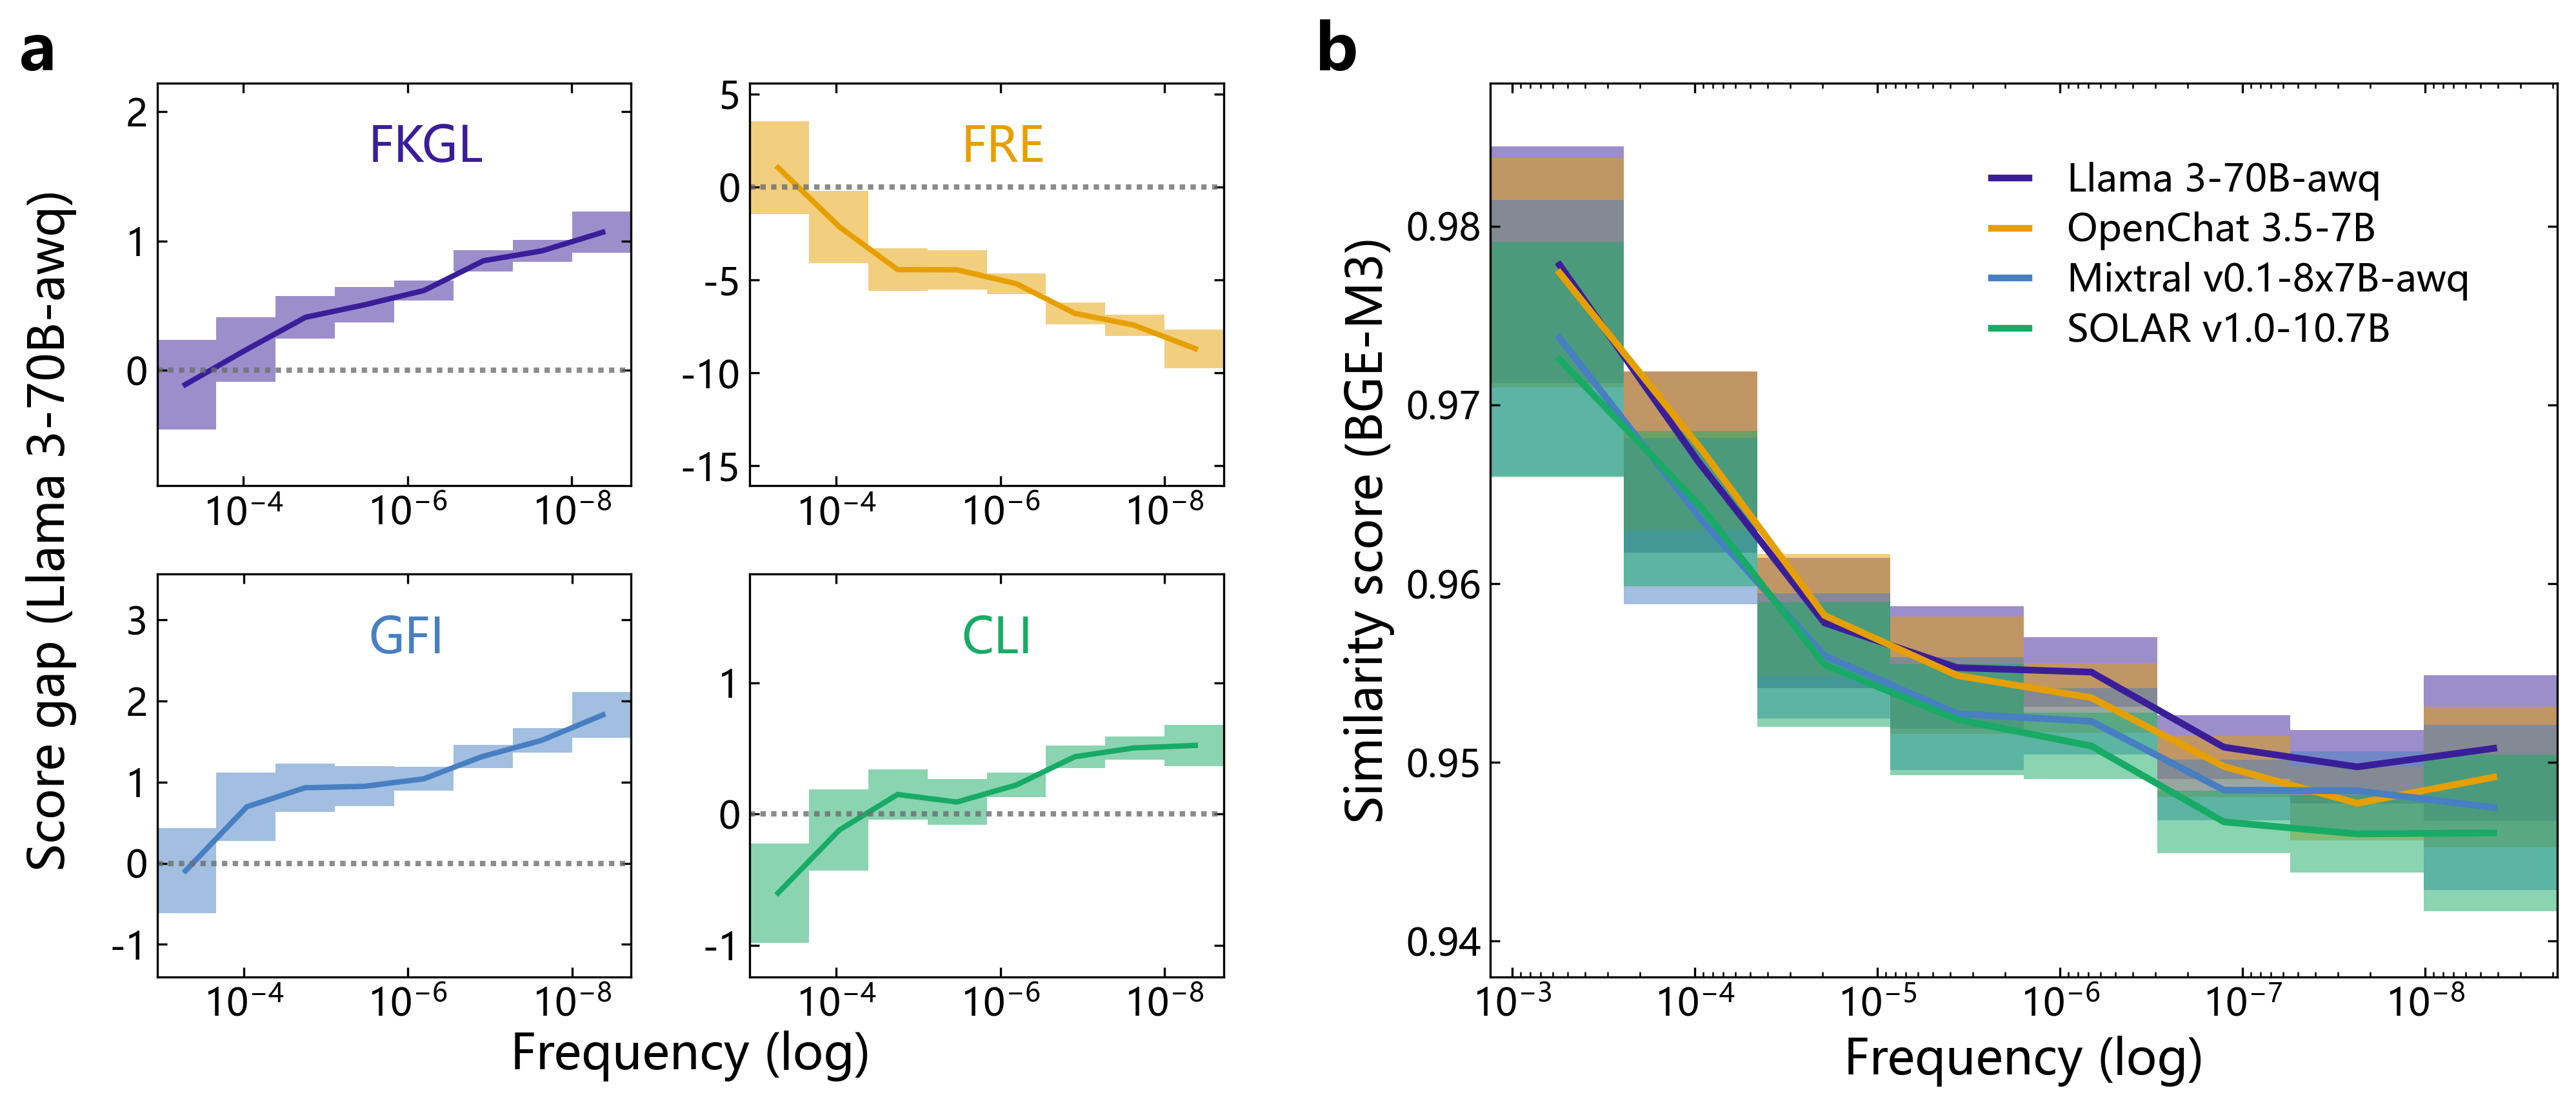

In [54]:
plt.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [8, 8]})

plotSubpanelA(axs[0], fig)
plotSubpanelB(axs[1])

fig.subplots_adjust(wspace=0.25, hspace=0.22)
# 添加字母
fig.text(0.0805, 0.935, 'a', fontsize=24, va='top', fontweight='bold')
fig.text(0.499, 0.935, 'b', fontsize=24, va='top', fontweight='bold')